**二维阻尼振荡器**

作为第一个说明性示例，我们考虑具有三次动态的二维阻尼谐振子，即：

$$
\begin{array}{l}
\dot{x} = -0.1\ x^3 + 2.0\ y^3,\\
\dot{y} = -2.0\ x^3 - 0.1\ y^3.
\end{array}
$$

我们使用初始条件 $[x_0\ y_0]^T = [2\ 0]^T$，并从 $t = 0$ 到 $t = 20$ 收集数据，时间步长为 $\Delta t = 0.01$。

### 原始代码  
BsplineKANLayer

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from BKAN import SplineLinearLayer
import random
from torch import autograd
from tqdm import tqdm
import os
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import nodepy.linear_multistep_method as lm
import torch.nn as nn
import torch.optim as optim


# Define the custom KAN layer
class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 num_knots=10, spline_order=3, 
                 noise_scale=0.1, base_scale=1.0, 
                 spline_scale=1.0, activation=nn.SiLU, 
                 grid_epsilon=0.02, grid_range=[-5, 5]):
        super(KANLayer, self).__init__()
        self.linear = SplineLinearLayer(in_features, out_features, num_knots, 
                                        spline_order, noise_scale, base_scale, 
                                        spline_scale, activation, grid_epsilon, grid_range)

    def forward(self, x):
        return self.linear(x)

# Define the combined model
class KANModel(nn.Module):
    def __init__(self):
        super(KANModel, self).__init__()
        self.kan_layer1 = KANLayer(2 ,5)    
        self.kan_layer2 = KANLayer(5, 2)  

    def forward(self, x):
        x = x.view(-1, 2)  # Flatten the input tensor
        x = self.kan_layer1(x)
        x = self.kan_layer2(x)
        return x
    
torch.set_default_dtype(torch.float64) # 设置默认张量数据类型为双精度浮点数

In [2]:
import timeit
# from scipy.signal import savgol_filter
from RTS import rts_smooth_column


# define solution
sol_fun_1 = lambda x:  (-0.1)* x[:,[0]]**3 + 2 * x[:,[1]]**3 
sol_fun_2 = lambda x:  (-2)* x[:,[0]]**3 + (-0.1) * x[:,[1]]**3 

start_time = timeit.default_timer()
torch.manual_seed(0)
# 超参数
n_steps = 2000            # 样本取点数               
steps = 6000              # 迭代次数
noise = 0               # 样本点的噪声
M = 1                     # 多步法的步数
y0 = np.array([0,1])      # 方程初始值
t0 = torch.from_numpy(np.array([0])).unsqueeze(0)  # 初始时间
t_np = np.linspace(0, 20, num=n_steps)
dt = t_np[M] - t_np[0]   # 步长


def f(x,t): # x is 2 x 1
    A = np.array([[-.1,2], [-2,-.1]]) # 2 x 2
    f = np.matmul(A,x[:,None]**3) # 2 x 1
    return f.flatten()

# 计算出微分方程的数值解，它使用 lsoda 方法进行数值积分，lsoda 方法使用了 Gear 公式的变步长、变阶数实现。它是一种隐式的多步法
y_np = odeint(f, y0, t_np) 
y_train = y_np[0::M,:]
y_train = y_train + noise*np.random.randn(y_train.shape[0], y_train.shape[1])


# window_length = 51
# polyorder = 3
# # y_train = savgol_filter(y_train, window_length=window_length, polyorder=polyorder)
# y_train = savgol_filter(y_train, window_length=window_length, polyorder=polyorder,axis=0)



# diff_y = np.diff(y_train, axis=0)
# # 估算的 std ≈ 差分的 std / 根号2
# estimated_noise_std = np.std(diff_y) / np.sqrt(2)

# y_train_smooth_0 = rts_smooth_column(y_train[:, 0], dt, estimated_noise_std)
# y_train_smooth_1 = rts_smooth_column(y_train[:, 1], dt, estimated_noise_std)
# y_train = np.stack([y_train_smooth_0, y_train_smooth_1], axis=1)


model = KANModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,betas=(0.9, 0.999),  eps=1e-32)

def net_Y(alpha,beta,T,y_train_new):
    Y = alpha[0] * T[:, M:, :] + dt * beta[0] * model(y_train_new[M:, :]).unsqueeze(0)
    for m in range(1, M + 1):
        Y = Y + alpha[m] * T[:, M-m:-m, :] + dt * beta[m] * model(y_train_new[M-m:-m, :]).unsqueeze(0) # S x (N-M+1) x D
    return Y


# 用于存储每次迭代的损失值
Train_loss_list = []
iteration_list = []

start_time = timeit.default_timer()
for epoch in range(steps):
    model.train()
    scheme = 'AM'
    switch = {'AM': lm.Adams_Moulton,
                'AB': lm.Adams_Bashforth,
                'BDF': lm.backward_difference_formula}
    method = switch[scheme](M)

    # 将 method.alpha 和 method.beta 转换为浮点数数组
    alpha = torch.tensor(-np.array(method.alpha[::-1], dtype=np.float32))
    beta = torch.tensor(np.array(method.beta[::-1], dtype=np.float32))

    y_train_new  = torch.tensor(y_train)
    T = y_train_new.unsqueeze(0)
    optimizer.zero_grad()
    Y_pred = net_Y(alpha,beta,T,y_train_new)
    loss = torch.mean((Y_pred)**2)
    loss.backward()
    optimizer.step()

    # 存储损失值和迭代次数
    Train_loss_list.append(loss.cpu().detach().numpy())
    iteration_list.append(epoch)

    if epoch % 1000 == 0:
        # print(f'Epoch {epoch+1}/{steps}, Train_loss: {loss.item(): .16e},  Test_loss: {Test_loss.item(): .16e}')
        print(f'Epoch {epoch+1}/{steps}, loss: {loss.item(): .16e}')

elapsed = timeit.default_timer() - start_time
print(f"Time: {elapsed:.4f}")

Epoch 1/6000, loss:  3.1392536723679769e-05
Epoch 1001/6000, loss:  1.3726975627315156e-08
Epoch 2001/6000, loss:  7.0270811973993442e-09
Epoch 3001/6000, loss:  6.3574527708708830e-10
Epoch 4001/6000, loss:  2.4942176730137084e-10
Epoch 5001/6000, loss:  1.4527398369574356e-10
Time: 185.9837


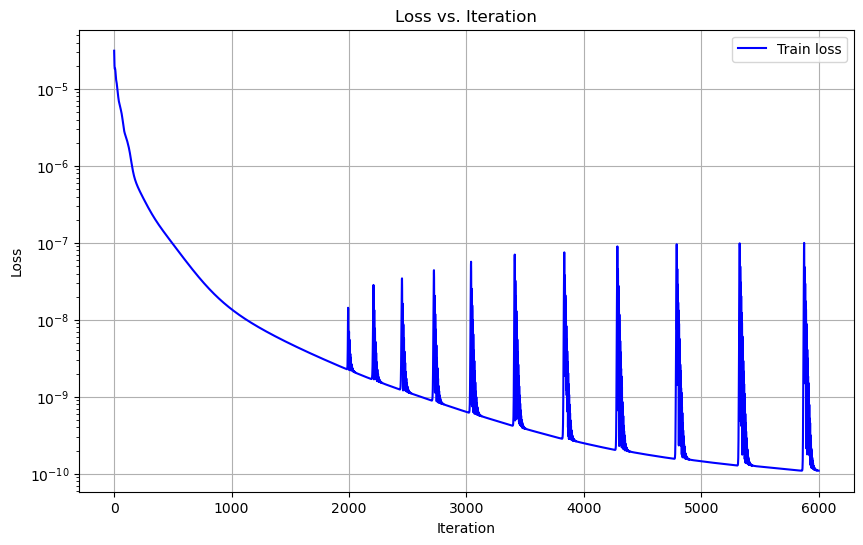

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(iteration_list, Train_loss_list, label='Train loss', color='b')
plt.yscale('log')
# plt.ylim(10e-15, 10e1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.legend()
plt.grid(True)
# plt.show()
# plt.savefig('Cubic2D_Error_10-6.png', format='png', dpi=600)

In [4]:
test_steps = n_steps
test_np = np.linspace(0, 20, test_steps)

def predict_f(y_star):
    y_star_tensor = torch.tensor(y_star)
    with torch.no_grad():
        F_star = model(y_star_tensor)
    return F_star.numpy()


def learned_f(x,t):
    f = predict_f(x[None,:])
    return f.flatten()


learned_X_star = odeint(learned_f, y0, test_np)     
lossx1 = np.max(learned_X_star[:,0]-y_np[:,0])
lossx2 = np.max(learned_X_star[:,1]-y_np[:,1])
print('x1_loss: {lossx1: .16e}, x2_loss: {lossx2: .16e}'.format(lossx1=lossx1, lossx2=lossx2))


x1_loss:  1.0881789802109243e-02, x2_loss:  7.3855520366696292e-03


C:\Users\14363\AppData\Local\Temp\ipykernel_20688\1968964672.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, 0:1])


Text(0.5, 1.0, 'Phase Portrait')

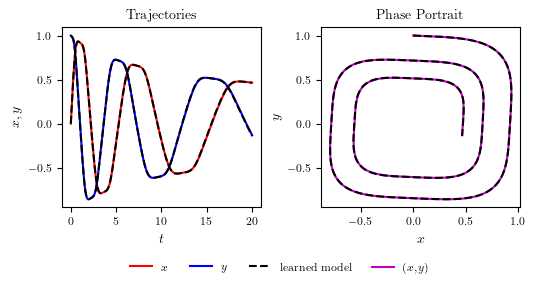

In [5]:
####### Plotting ################## 
import matplotlib.gridspec as gridspec
from plotting import newfig, savefig

fig, ax = newfig(1.0, 0.9)
ax.axis('off')

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.85, bottom=0.25, left=0.1, right=0.95, wspace=0.3)

ax = plt.subplot(gs0[:, 0:1])
ax.plot(test_np,y_np[:,0],'r',label='$x$')
ax.plot(test_np,y_np[:,1],'b',label='$y$')
ax.plot(test_np,learned_X_star[:,0],'k--',label='learned model')
ax.plot(test_np,learned_X_star[:,1],'k--')    
ax.set_xlabel('$t$')
ax.set_ylabel('$x, y$')
ax.legend(loc='upper center', bbox_to_anchor=(0.9, -0.25), ncol=3, frameon=False)
ax.set_title('Trajectories', fontsize = 10)

ax = plt.subplot(gs0[:, 1:2])
ax.plot(y_np[:,0],y_np[:,1], 'm', label='$(x,y)$')
ax.plot(learned_X_star[:,0],learned_X_star[:,1],'k--')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc='upper center', bbox_to_anchor=(0.4, -0.25), ncol=1, frameon=False)
ax.set_title('Phase Portrait', fontsize = 10)

# plt.savefig('Cubic2Dx_xnn25_0.005.png', format='png', dpi=600)